In [7]:
import torch
import random
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, UnidentifiedImageError
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import itertools
import torchvision
from torch.optim import SGD
import torch.nn as nn

from pytorch_lightning.loggers import TensorBoardLogger


np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

NUM_EPOCHS=50

In [8]:

class PairDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        # Collect all image paths and labels
        self.image_paths = []
        self.labels = []

        # Create a mapping from folder names to labels
        self.label_mapping = {label: idx for idx, label in enumerate("abcdefghiklmnopqrstuvwxyz")}
        
        for subject in os.listdir(root):
            subject_path = os.path.join(root, subject)
            if os.path.isdir(subject_path):
                for label in os.listdir(subject_path):
                    if label in self.label_mapping:  # only process valid labels
                        label_path = os.path.join(subject_path, label)
                        if os.path.isdir(label_path):
                            for image_name in os.listdir(label_path):
                                image_path = os.path.join(label_path, image_name)
                                # Check if the file is a valid image
                                try:
                                    Image.open(image_path).verify()
                                    self.image_paths.append(image_path)
                                    self.labels.append(self.label_mapping[label])
                                except (IOError, UnidentifiedImageError):
                                    continue

        self.labels = np.array(self.labels)
        
        # Create a list of indices for each class
        self.class_to_indices = [np.where(self.labels == idx)[0] for idx in range(len(self.label_mapping))]
        
        # Generate pairs
        self.generate_pairs()

    def generate_pairs(self):
        """Generates pairs, associating each element with a new element."""
        self.pair_labels = (np.random.rand(len(self.image_paths)) > 0.5).astype(int)
        self.paired_idx = []

        for i, l in enumerate(self.pair_labels):
            c1 = self.labels[i]
            if l == 0:  # similar pair
                j = np.random.choice(self.class_to_indices[c1])
            else:  # dissimilar pair
                diff_class = np.random.choice(list(set(range(len(self.label_mapping))) - {c1}))
                j = np.random.choice(self.class_to_indices[diff_class])
            self.paired_idx.append(j)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        im1_path = self.image_paths[i]
        im2_path = self.image_paths[self.paired_idx[i]]
        
        im1 = Image.open(im1_path).convert('L')
        im2 = Image.open(im2_path).convert('L')

        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        
        l = self.pair_labels[i]
        l1 = self.labels[i]
        l2 = self.labels[self.paired_idx[i]]

        return im1, im2, l, l1, l2

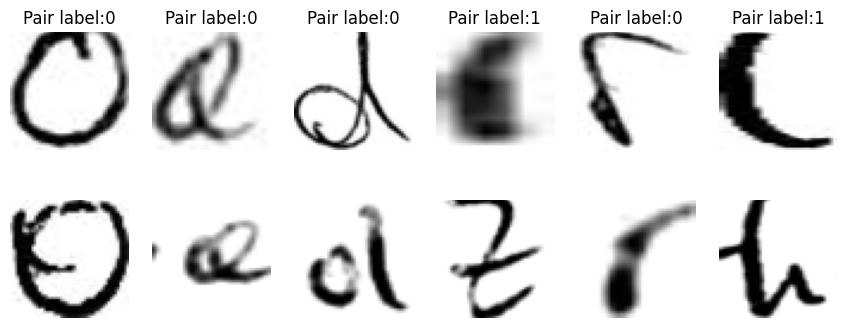

In [9]:
from torchvision import transforms

pair_dataset = PairDataset(root='dataset', transform=transforms.Compose([
    transforms.Resize((50,50)),
    transforms.ToTensor()
]))

plt.figure(figsize=(18, 4))
for ii, i in enumerate(np.random.choice(range(len(pair_dataset)), 6)):
    plt.subplot(2, 10, ii + 1)
    plt.title('Pair label:' + str(pair_dataset[i][2]))
    plt.imshow(pair_dataset[i][0].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 10, ii + 11)
    plt.imshow(pair_dataset[i][1].squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

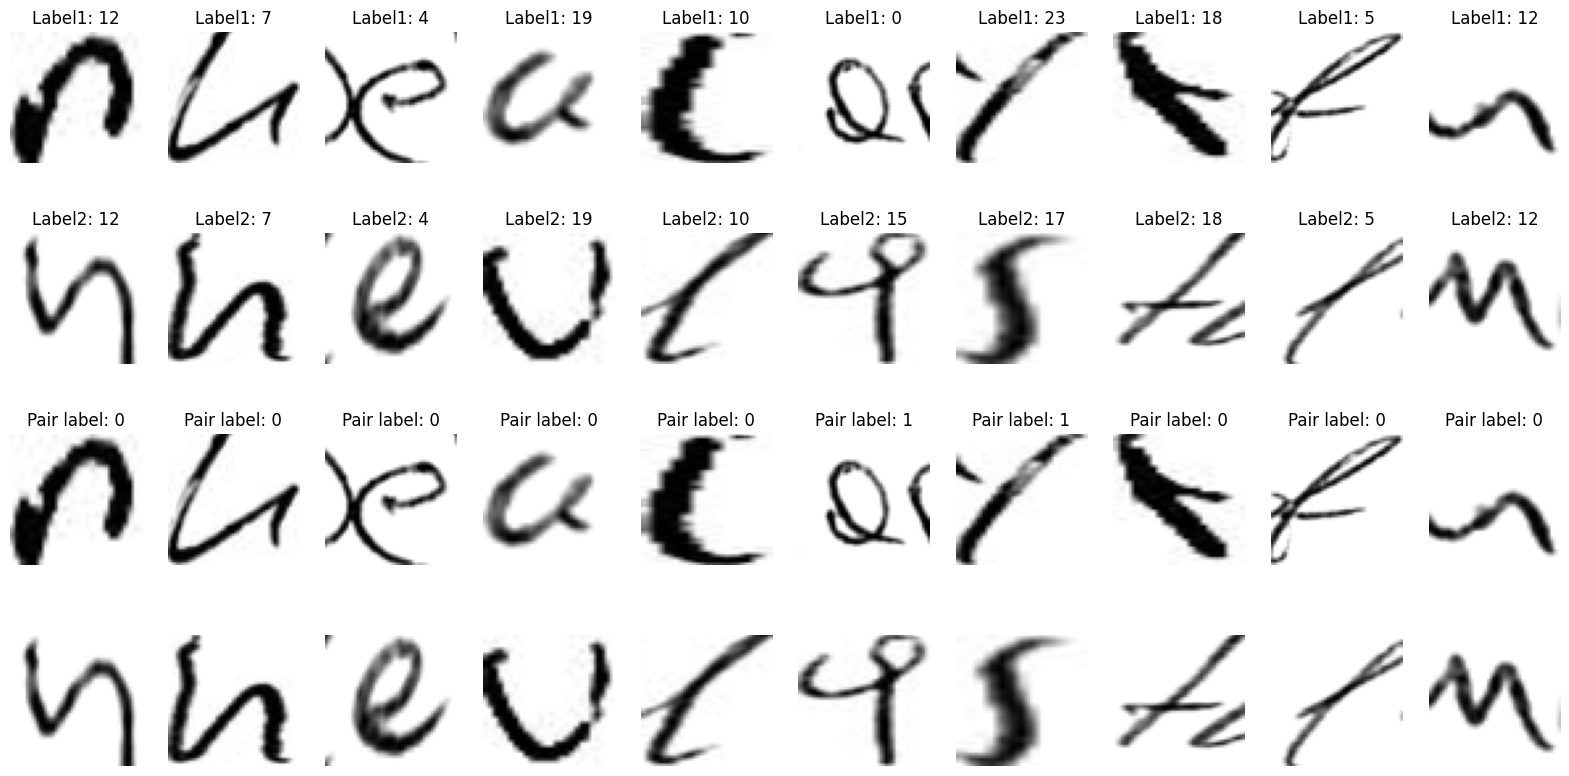

In [10]:
def verify_labels(dataset, num_samples=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        im1, im2, pair_label, label1, label2 = dataset[idx]

        plt.subplot(4, num_samples, i + 1)
        plt.title(f'Label1: {label1}')
        plt.imshow(im1.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + num_samples)
        plt.title(f'Label2: {label2}')
        plt.imshow(im2.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
        plt.title(f'Pair label: {pair_label}')
        plt.imshow(im1.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
        plt.imshow(im2.squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show()

verify_labels(pair_dataset, num_samples=10)

<h1>RESNET SIAMESE</h1>

In [11]:
from torchvision.models import resnet18


class ResNetEmbedding(nn.Module):
    def __init__(self):
        super(ResNetEmbedding, self).__init__()
        self.resnet = resnet18(pretrained=True)
        
        # Modifica del primo livello convoluzionale per accettare input a canale singolo
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Modifica dell'ultimo livello completamente connesso
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 128)
    
    def forward(self, x):
        return self.resnet(x)

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=2):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, phi_i, phi_j, l_ij):
        d = F.pairwise_distance(phi_i, phi_j)
        l = 0.5 * (1 - l_ij.float()) * torch.pow(d,2) + \
            0.5 * l_ij.float() * torch.pow( torch.clamp( self.m - d, min = 0) , 2)
        return l.mean()

class SiameseNetworkTask(pl.LightningModule):
    def __init__(self, 
                 embedding_net, # la rete di embedding
                 lr=0.01, # il learning rate
                 momentum=0.99, # momentum
                 margin=2 # margine per la loss
                ):
        super(SiameseNetworkTask, self).__init__()
        self.save_hyperparameters()
        self.embedding_net = embedding_net
        self.criterion = ContrastiveLoss(margin) # definiamo la loss
                    
    def forward(self, x):
        return self.embedding_net(x)
        
    def configure_optimizers(self):
        return SGD(self.embedding_net.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
    
    def training_step(self, batch, batch_idx):
        # preleviamo gli elementi I_i e I_j e l'etichetta l_ij
        # scartiamo il resto (le etichette dei singoli elementi)
        I_i, I_j, l_ij, *_ = batch
        
        # l'implementazione della rete siamese è banale:
        # eseguiamo la embedding net sui due input
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)

        # calcoliamo la loss
        l = self.criterion(phi_i, phi_j, l_ij)
        
        self.log('train/loss', l)
        return l
    
    def validation_step(self, batch, batch_idx):
        I_i, I_j, l_ij, *_ = batch
        phi_i = self.embedding_net(I_i)
        phi_j = self.embedding_net(I_j)
        l = self.criterion(phi_i, phi_j, l_ij)
        self.log('valid/loss', l)
        
        if batch_idx==0:
            self.logger.experiment.add_embedding(phi_i, batch[3], I_i, global_step=self.global_step) 

resnet_embedding_net = ResNetEmbedding()

siamese_network_task = SiameseNetworkTask(resnet_embedding_net)

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'embedding_net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['embedding_net'])`.


In [14]:
transform = transforms.Compose([
    transforms.Resize((50,50)),  
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

full_dataset = PairDataset(root='dataset', transform=transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024)

In [15]:
# Verify the number of images loaded in the DataLoader
def count_images_in_dataloader(dataloader):
    total_images = 0
    for batch in dataloader:
        im1, im2, l, l1, l2 = batch
        total_images += im1.size(0)
    return total_images

# Count images in train and test DataLoader
total_train_images = count_images_in_dataloader(train_loader)
total_test_images = count_images_in_dataloader(test_loader)

print(f"Total images in train DataLoader: {total_train_images}")
print(f"Total images in test DataLoader: {total_test_images}")

Total images in train DataLoader: 10596
Total images in test DataLoader: 2650


In [1]:
from pytorch_lightning.loggers import TensorBoardLogger
'''
logger = TensorBoardLogger("logs", name="siamese_resnet")
trainer = pl.Trainer( logger=logger, max_epochs=NUM_EPOCHS, enable_progress_bar=True)

trainer.fit(siamese_network_task, train_loader, test_loader)
'''

'\nlogger = TensorBoardLogger("logs", name="siamese_resnet")\ntrainer = pl.Trainer( logger=logger, max_epochs=NUM_EPOCHS, enable_progress_bar=True)\n\ntrainer.fit(siamese_network_task, train_loader, test_loader)\n'

In [16]:
# Salvataggio del modello
'''
torch.save(siamese_network_task.state_dict(), 'models/siamese_resnet2.pth')
'''

In [17]:
model = SiameseNetworkTask(ResNetEmbedding())
model.load_state_dict(torch.load('models/siamese_resnet2.pth'))

C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\orazi\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'embedding_net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['embedding_net'])`.


<All keys matched successfully>

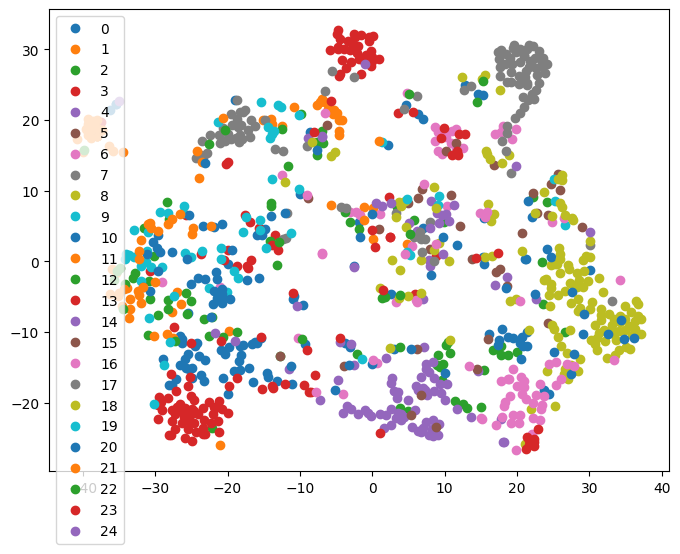

In [20]:
def extract_representations(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)
    representations, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        rep = model(x)
        rep = rep.detach().to('cpu').numpy()
        labels.append(batch[3].numpy())  # Assuming batch[3] contains labels in your dataset
        representations.append(rep)
    return np.concatenate(representations), np.concatenate(labels)

# Trasformazione delle immagini per il tuo dataset
transform = transforms.Compose([
    transforms.Resize((50,50)),  
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

# Creazione del dataset e del DataLoader
full_dataset = PairDataset(root='dataset', transform=transform)

# Split del dataset in 80% training e 20% testing
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
_, test_dataset = random_split(full_dataset, [train_size, test_size])

test_loader = DataLoader(test_dataset, batch_size=1024)

# Estrazione delle rappresentazioni dal modello di embedding
test_representations, test_labels = extract_representations(model.embedding_net, test_loader)

# Visualizzazione delle rappresentazioni usando TSNE
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

selected_rep = np.random.choice(len(test_representations), 1000, replace=False)
selected_test_representations = test_representations[selected_rep]
selected_test_labels = test_labels[selected_rep]

tsne = TSNE(2)
rep_tsne = tsne.fit_transform(selected_test_representations)

plt.figure(figsize=(8,6))
for c in np.unique(selected_test_labels):
    plt.plot(rep_tsne[selected_test_labels == c, 0], rep_tsne[selected_test_labels == c, 1], 'o', label=c)
plt.legend()
plt.show()